Author: Xiaogang He (hexg@princeton.edu), http://hydro.iis.u-tokyo.ac.jp/~hexg

The `%matplotlib` magic command is used here to enable plotting in the current notebook. The `inline` backend will embed plots inside the notebook.

In [1]:
%matplotlib inline

### Import necessary modules 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

### Read USGS observations

In [3]:
def read_peak_discharge(gageID):
    df = pd.read_csv('../Data/%s.txt' % (gageID), header=None, names=['Year', 'Month', 'Day', 'Discharge', 'Stage'])

    return df

In [4]:
obs = read_peak_discharge('01401000')
year = obs['Year']
peak = obs['Discharge']

In [5]:
obs

,Year,Month,Day,Discharge,Stage
0,1953,12,14,3000,8.66
1,1955,8,13,5130,11.90
2,1955,10,15,3420,9.35
3,1957,4,5,2260,7.37
4,1958,2,28,4150,10.46
5,1959,3,6,2460,7.73
6,1960,9,12,4400,10.85
7,1961,7,29,3480,9.44
8,1962,3,12,3520,9.50
9,1963,3,6,2120,7.10


In [6]:
peak

0      3000
1      5130
2      3420
3      2260
4      4150
5      2460
6      4400
7      3480
8      3520
9      2120
10     3340
11     2280
12     2170
13     4120
14     3600
15     3480
16     3060
17     8960
18     2750
19     3670
20     4290
21     4980
22     2110
23     2890
24     3900
25     4410
26     3980
27     2430
28     3550
29     4220
30     5350
31     2500
32     3780
33     3680
34     2290
35     3120
36     2540
37     1920
38     3090
39     2870
40     5530
41     2100
42     7210
43     6290
44     4210
45     8780
46     2260
47     3050
48     2950
49     3440
50     4490
51     4030
52     5550
53     5760
54     4370
55     4680
56     5330
57    10600
58     3390
59     4150
Name: Discharge, Length: 60, dtype: int64

### Plot annual peak discharge observations

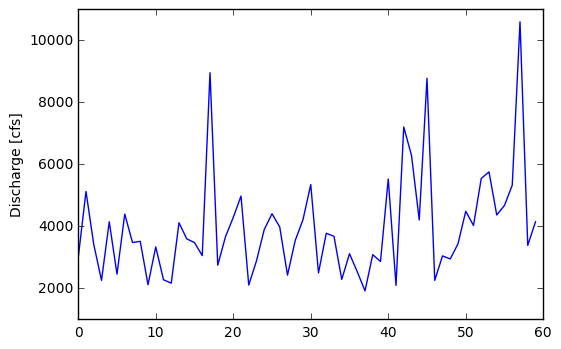

In [15]:
plt.plot(peak)
plt.ylabel('Discharge [cfs]')

## Use rpy2 to access R from within python

### Convert the format 

In [8]:
peak = FloatVector(peak)
r.assign('peak', peak)

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x10b635950 / R:0x1004ceb80>
[3000.000000, 5130.000000, 3420.000000, ..., 10600.000000, 3390.000000, 4150.000000]

### Test for trend in annual peak data

MannKendall test is used to detect monotonic trend based on Kendall rank correaltion.

In [9]:
importr('Kendall')
print r("MannKendall(peak)")

tau = 0.197, 2-sided pvalue =0.026442



### Test for change point in annual peak data

In [10]:
importr('strucchange')
r("bp.peak <- breakpoints(peak ~ 1)")
print r("bp.peak$breakpoints")

[1] 42



###  Calculate the return period

In [11]:
def calculate_return_period(EVD, rp):

    importr('ismev')
    r.assign('rp', rp)

    if EVD == 'GEV':
        r("fit.obj <- gev.fit(peak)")
        r("pars <- fit.obj$mle")
        rl = r("gevq(fit.obj$mle, 1./rp)")[0]
        r.pdf(file='./%s_diag.pdf' % (EVD), width=8, height=8)
        r("gev.diag(fit.obj)")
        r("dev.off()")
    elif EVD == 'Gumbel':
        r("fit.obj <- gum.fit(peak)")
        r("pars <- fit.obj$mle")
        rl = r("gum.q(1.0/rp, pars[1], pars[2])")[0]
        r.pdf(file='./%s_diag.pdf' % (EVD), width=8, height=8)
        r("gum.diag(fit.obj)")
        r("dev.off()")

    return rl

In [12]:
rl_gev = calculate_return_period('GEV', 100)
rl_gum = calculate_return_period('Gumbel', 100)

$conv
[1] 0

$nllh
[1] 516.8577

$mle
[1] 3134.2030365 1011.3624690    0.2062548

$se
[1] 152.4992884 122.4542309   0.1233884

$conv
[1] 0

$nllh
[1] 518.8994

$mle
[1] 3254.967 1120.662

$se
[1] 151.2473 118.3372



In [13]:
print rl_gev
print rl_gum

10894.4998374
8410.1796258
